### Current Issue 7/3
1. Determine how many samples to use (segments)
2. Determine the exact artifact removal method
3. Increase the overall accuracy

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import mne
import random

## Feature extraction method
from scipy import signal
from sklearn.decomposition import FastICA, PCA

### Dataset
Using a person's 3 different mental states, relaxed, neutral, concetrating<br>
- `trials = 3, channels = 4, samples = 15204 * 0.75, kernels = 1`

#### Demo 1, using a subset of dataset

In [2]:
sub_a_relaxed = pd.read_csv(os.getcwd() + '/eeg-feature-generation/dataset/original_data/subjecta-relaxed-1.csv')
print('sub_a_relaxed\' shape: {}'.format(sub_a_relaxed.shape))

sub_a_neutral = pd.read_csv(os.getcwd() + '/eeg-feature-generation/dataset/original_data/subjecta-neutral-1.csv')
print('sub_a_neutral\' shape: {}'.format(sub_a_neutral.shape))

sub_a_concentrating = pd.read_csv(os.getcwd() + '/eeg-feature-generation/dataset/original_data/subjecta-concentrating-1.csv')
print('sub_a_concentrating\' shape: {}'.format(sub_a_concentrating.shape))

sub_a_relaxed' shape: (15204, 6)
sub_a_neutral' shape: (15204, 6)
sub_a_concentrating' shape: (15192, 6)


#### Demo 2, using the whole dataset
- Matched the number of samples to 888, the df with the lowest number of rows

In [251]:
directory = os.getcwd() + '/eeg-feature-generation/dataset/original_data/'
files = os.listdir(directory)
random.shuffle(files)

data = []
labels = []


for filename in files:
    if 'subject' in filename:
        df = pd.read_csv(directory + filename)
        df = df.drop(columns=['timestamps','Right AUX'])
        df = df[:888]
        if 'relaxed' in filename:
            labels.append(0)
        elif 'neutral' in filename:
            labels.append(1)
        elif 'concentrating' in filename:
            labels.append(2)
        data.append(df)
        if len(df) < 15192:
            print('{}, shape = ({})'.format(filename, df.shape))
labels = np.array(labels)

subjecta-concentrating-1.csv, shape = ((888, 4))
subjectd-neutral-2.csv, shape = ((888, 4))
subjectd-neutral-1.csv, shape = ((888, 4))
subjecta-neutral-1.csv, shape = ((888, 4))
subjectb-concentrating-2.csv, shape = ((888, 4))
subjectb-relaxed-1.csv, shape = ((888, 4))
subjectb-neutral-2.csv, shape = ((888, 4))
subjectb-neutral-1.csv, shape = ((888, 4))
subjectd-concentrating-1.csv, shape = ((888, 4))
subjectd-concentrating-2.csv, shape = ((888, 4))
subjectc-neutral-1.csv, shape = ((888, 4))
subjecta-neutral-2.csv, shape = ((888, 4))
subjecta-relaxed-2.csv, shape = ((888, 4))
subjectc-concentrating-1.csv, shape = ((888, 4))
subjectb-concentrating-1.csv, shape = ((888, 4))
subjecta-concentrating-2.csv, shape = ((888, 4))
subjectc-relaxed-1.csv, shape = ((888, 4))
subjectd-relaxed-2.csv, shape = ((888, 4))
subjectc-neutral-2.csv, shape = ((888, 4))
subjecta-relaxed-1.csv, shape = ((888, 4))
subjectd-relaxed-1.csv, shape = ((888, 4))
subjectc-relaxed-2.csv, shape = ((888, 4))
subjectb-rel

In [252]:
data = np.array([np.transpose(df) for df in data])
print(data.shape)
data

(24, 4, 888)


array([[[ 59.105,  62.012,  44.922, ...,  15.625,  34.18 ,  45.898],
        [ 28.32 ,  30.273,  30.273, ...,  31.738,  35.156,  35.156],
        [ 15.137,  43.945, -97.656, ..., -60.059,  23.926, 112.793],
        [ 12.207,  11.719,  11.23 , ...,   8.789,   8.789,  13.184]],

       [[ -1.465,   8.301,  20.996, ...,  14.648,  12.207,  17.578],
        [  6.836,   6.348,   7.812, ...,  13.672,  10.742,  10.254],
        [ 12.695,  -2.93 ,   0.488, ...,  14.648,   5.859,  -3.906],
        [-77.148, -81.055, -75.195, ..., -77.148, -78.613, -78.613]],

       [[ 53.223,  45.41 ,  34.18 , ...,  25.879,  43.457,  40.527],
        [ 23.926,  20.996,  19.043, ...,  30.762,  29.297,  26.855],
        [ 14.16 ,  14.16 ,   5.371, ...,  24.414,  30.273,  25.879],
        [  0.977,   5.371,   4.395, ..., -13.184,  -4.395,   0.977]],

       ...,

       [[ 18.066,  33.691,  24.902, ...,  -0.488,   0.977,  22.949],
        [ 11.719,  20.996,  21.973, ...,  19.043,  13.672,  12.695],
        [ -4.39

#### Label
- 0.0 = relaxed<br>
- 1.0 = neutral<br>
- 2.0 = concetrating

In [253]:
labels

array([2, 1, 1, 1, 2, 0, 1, 1, 2, 2, 1, 1, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0,
       0, 2])

### Preprocessing
- Convert data to NHWC (trials, channels, samples, kernels) format

#### Data Cleaning
- Drop unnecessary columns = `['timestamps','Right AUX']`
- Match the number of samples = `15192`

In [ ]:
sub_a_relaxed = sub_a_relaxed.drop(columns=['timestamps','Right AUX'])
sub_a_neutral = sub_a_neutral.drop(columns=['timestamps','Right AUX'])
sub_a_concentrating = sub_a_concentrating.drop(columns=['timestamps','Right AUX'])

In [15]:
sub_a_relaxed = sub_a_relaxed[:15192]
sub_a_neutral = sub_a_neutral[:15192]

print('sub_a_relaxed\' shape: {}'.format(sub_a_relaxed.shape))
print('sub_a_neutral\' shape: {}'.format(sub_a_neutral.shape))
print('sub_a_concentrating\' shape: {}'.format(sub_a_concentrating.shape))

sub_a_relaxed' shape: (15192, 4)
sub_a_neutral' shape: (15192, 4)
sub_a_concentrating' shape: (15192, 4)


In [24]:
X = np.array([np.transpose(sub_a_relaxed), np.transpose(sub_a_neutral), np.transpose(sub_a_concentrating)])
print(X.shape)
X

(3, 4, 15192)


array([[[ 30.762,  26.367,  21.484, ...,  21.484,  20.996,  33.203],
        [ 15.625,  13.672,  14.16 , ...,  22.949,  21.973,  22.461],
        [ 29.785,  28.32 ,  28.32 , ...,  34.18 ,  33.691,  31.738],
        [  0.977,   0.   ,   2.93 , ...,  11.23 ,   5.859,  10.254]],

       [[  4.883,  19.531,  20.508, ...,  34.668,  35.156,  20.02 ],
        [ 22.949,  22.461,  19.531, ...,  33.203,  32.715,  30.273],
        [  8.789,   5.371,  11.23 , ...,  16.602,  18.555,  10.254],
        [ 23.926,  28.32 ,  25.391, ...,  25.391,  35.156,  18.555]],

       [[ 59.105,  62.012,  44.922, ...,  48.828,  50.293,  45.41 ],
        [ 28.32 ,  30.273,  30.273, ...,  31.25 ,  31.25 ,  30.273],
        [ 15.137,  43.945, -97.656, ..., 258.789, 264.16 ,  27.344],
        [ 12.207,  11.719,  11.23 , ...,  38.086,  39.551,  39.062]]])

#### Label
- 0.0 = relaxed<br>
- 1.0 = neutral<br>
- 2.0 = concetrating

In [28]:
Y = np.array([0.0, 1.0, 2.0])
print(Y.shape)
Y

(3,)


array([0., 1., 2.])

### Feature Extraction - Denoising
Fast Fourier Transform (FFT) - A method to remove the artifact from the recorded data, such as eye blinks

[ 0.00000000e+00  6.57721652e-05  1.31544330e-04 ... -1.97316496e-04
 -1.31544330e-04 -6.57721652e-05]


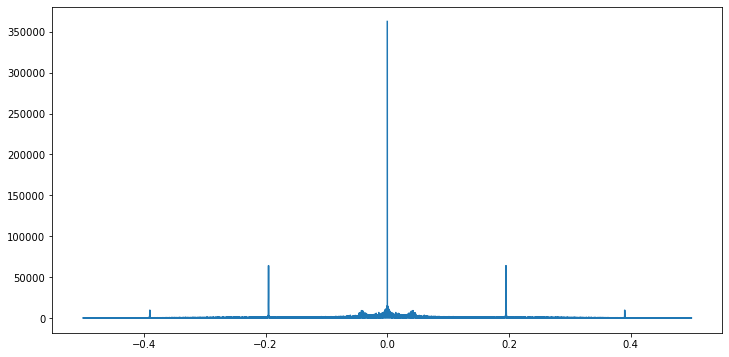

In [4]:
import numpy.fft as fft
spectrum = fft.fft(sub_a_relaxed['TP9'], sub_a_relaxed.shape[0])
freq = fft.fftfreq(len(spectrum))
print(freq)
plt.figure(figsize=(12,6))
plt.plot(freq, abs(spectrum))

### Model - EEGNet (Proven to be effective in classifying EEG Data)
Parameter settings so far: nb_classes=3, as there are 3 classes to classify: relaxed, neutral, concentrating<br>

Paper - https://arxiv.org/pdf/1611.08024.pdf <br>
Github - https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py <br>

### First Demo with 15192 samples (1 min period of mental state)

In [78]:
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
model  = EEGNet(nb_classes=3, Chans=4, Samples=X.shape[2],
                dropoutRate = 0.5, kernLength=int(X.shape[2]/2), 
                F1=8, D=2, F2=16, dropoutType = 'Dropout')
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4, 15192, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 15192, 8)       60768     
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 15192, 8)       32        
_________________________________________________________________
depthwise_conv2d_4 (Depthwis (None, 1, 15192, 16)      64        
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 15192, 16)      64        
_________________________________________________________________
activation_8 (Activation)    (None, 1, 15192, 16)      0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 1, 3798, 16)       0   

In [64]:
X_train = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X_train.shape

(3, 4, 15192, 1)

In [79]:
model.fit(X_train, Y_train, batch_size = 128, epochs=5)

Epoch 1/5
1/1 [==============================] - 9s 9s/step - loss: 1.2772 - accuracy: 0.6667
Epoch 2/5
1/1 [==============================] - 8s 8s/step - loss: 0.7128 - accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 8s 8s/step - loss: 0.2945 - accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 8s 8s/step - loss: 0.1381 - accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 9s 9s/step - loss: 0.0612 - accuracy: 1.0000


In [94]:
# Using as a test dataset
sub_b_relaxed = pd.read_csv(os.getcwd() + '/eeg-feature-generation/dataset/original_data/subjectb-relaxed-1.csv')
sub_b_relaxed = sub_b_relaxed.drop(columns=['timestamps','Right AUX'])
sub_b_relaxed = sub_b_relaxed[:15192]
print('sub_b_relaxed shape: {}'.format(sub_b_relaxed.shape))

sub_b_relaxed shape: (15192, 4)


In [95]:
X_test = np.array([np.transpose(sub_b_relaxed)])
print(X_test.shape)
X_test

(1, 4, 15192)


array([[[ 43.457,  57.617,  41.504, ...,  17.09 ,  21.973,  47.363],
        [ 39.551,  40.039,  41.016, ...,  22.949,  30.762,  35.156],
        [ 48.828,  48.34 ,  47.852, ...,  22.949,  20.508,  27.832],
        [ 19.043,  23.438,  25.879, ..., -19.043, -20.508, -13.672]]])

In [96]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_test.shape

(1, 4, 15192, 1)

In [119]:
Y_test = np.array([0])
print(Y_test.shape)
Y_test

(1,)


array([0])

In [120]:
Y_test = np_utils.to_categorical(Y_test, num_classes=3)
print(Y_test.shape)
Y_test

(1, 3)


array([[1., 0., 0.]], dtype=float32)

In [102]:
probs = model.predict(X_test)
probs

array([[0.10493065, 0.13374467, 0.7613246 ]], dtype=float32)

In [100]:
preds = probs.argmax(axis = -1)  
preds

array([2], dtype=int64)

In [121]:
acc = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.000000 


In [81]:
model.save('suba-1_checkpoint.h5')

### Second Demo

In [267]:
kernels, chans, samples = 1, 4, 888

In [268]:
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
model  = EEGNet(nb_classes=3, Chans=chans, Samples=samples,
                dropoutRate = 0.5, kernLength=int(samples/2), 
                F1=8, D=2, F2=16, dropoutType = 'Dropout')
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 4, 888, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 888, 8)         3552      
_________________________________________________________________
batch_normalization_18 (Batc (None, 4, 888, 8)         32        
_________________________________________________________________
depthwise_conv2d_6 (Depthwis (None, 1, 888, 16)        64        
_________________________________________________________________
batch_normalization_19 (Batc (None, 1, 888, 16)        64        
_________________________________________________________________
activation_12 (Activation)   (None, 1, 888, 16)        0         
_________________________________________________________________
average_pooling2d_12 (Averag (None, 1, 222, 16)        0   

In [258]:
X_train = data[:18]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print('X_train.shape = {}'.format(X_train.shape))

X_test = data[18:21]
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('X_test.shape = {}'.format(X_test.shape))

X_val = data[21:24]
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
print('X_val.shape = {}'.format(X_val.shape))

X_train.shape = (18, 4, 888, 1)
X_test.shape = (3, 4, 888, 1)
X_val.shape = (3, 4, 888, 1)


In [259]:
labels

array([2, 1, 1, 1, 2, 0, 1, 1, 2, 2, 1, 1, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0,
       0, 2])

In [270]:
from tensorflow.keras import utils as np_utils
Y_train = labels[:18]
Y_train = np_utils.to_categorical(Y_train, num_classes=3)
print('Y_train.shape = {}'.format(Y_train.shape))


Y_test = labels[18:21]
Y_test = np_utils.to_categorical(Y_test, num_classes=3)
print('Y_test.shape = {}'.format(Y_test.shape))

Y_val = labels[21:24]
Y_val = np_utils.to_categorical(Y_val, num_classes=3)
print('Y_val.shape = {}'.format(Y_val.shape))

Y_train.shape = (18, 3)
Y_test.shape = (3, 3)
Y_val.shape = (3, 3)


In [274]:
model.fit(X_train, Y_train, batch_size = 16, epochs=5,
         verbose = 2, validation_data=(X_val, Y_val))

Epoch 1/5
2/2 - 0s - loss: 0.7189 - accuracy: 0.7222 - val_loss: 1.1016 - val_accuracy: 0.3333
Epoch 2/5
2/2 - 0s - loss: 0.7414 - accuracy: 0.7222 - val_loss: 1.1017 - val_accuracy: 0.3333
Epoch 3/5
2/2 - 0s - loss: 0.6490 - accuracy: 0.7222 - val_loss: 1.1023 - val_accuracy: 0.0000e+00
Epoch 4/5
2/2 - 0s - loss: 0.6755 - accuracy: 0.7222 - val_loss: 1.1057 - val_accuracy: 0.0000e+00
Epoch 5/5
2/2 - 0s - loss: 0.6400 - accuracy: 0.8333 - val_loss: 1.1034 - val_accuracy: 0.0000e+00


In [275]:
probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.333333 
